In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
AAPL_data_path = "AAPL_data/AAPL_2024-10-03_xnas-itch.parquet"

df = pd.read_parquet(AAPL_data_path)
df = df.reset_index().set_index("ts_event")

df.head()

,ts_recv,rtype,publisher_id,instrument_id,action,side,depth,price,size,flags,...,bid_ct_08,ask_ct_08,bid_px_09,ask_px_09,bid_sz_09,ask_sz_09,bid_ct_09,ask_ct_09,symbol,date
ts_event,,,,,,,,,,,,,,,,,,,,,
2024-10-03 04:00:00.035617078-04:00,2024-10-03 04:00:00.035783424-04:00,10,2,38,A,N,0,223.21,440,130,...,0,0,NaN,NaN,0,0,0,0,AAPL,2024-10-03
2024-10-03 04:00:00.035869514-04:00,2024-10-03 04:00:00.036035156-04:00,10,2,38,A,A,0,227.79,440,130,...,0,0,NaN,NaN,0,0,0,0,AAPL,2024-10-03
2024-10-03 04:00:00.188545359-04:00,2024-10-03 04:00:00.188729434-04:00,10,2,38,A,A,1,228.00,1000,128,...,0,0,NaN,NaN,0,0,0,0,AAPL,2024-10-03
2024-10-03 04:00:00.188582194-04:00,2024-10-03 04:00:00.188787632-04:00,10,2,38,A,B,1,223.00,2000,128,...,0,0,NaN,NaN,0,0,0,0,AAPL,2024-10-03
2024-10-03 04:00:00.189844175-04:00,2024-10-03 04:00:00.190112774-04:00,10,2,38,A,A,2,228.20,2000,128,...,0,0,NaN,NaN,0,0,0,0,AAPL,2024-10-03


In [3]:
df["mid_price"] = df[["ask_px_00", "bid_px_00"]].mean(axis=1)
df["mid_price"] = df["mid_price"].combine_first(df["ask_px_00"])
df["mid_price"] = df["mid_price"].combine_first(df["bid_px_00"])

In [4]:
# Resample the mid_price values by second to get highest, lowest, and close prices
sampling_rate = '2s'

mid_prices_high = df["mid_price"].resample(sampling_rate).max().ffill()
mid_prices_low = df["mid_price"].resample(sampling_rate).min().ffill()
mid_prices_close = df["mid_price"].resample(sampling_rate).last().ffill()
mid_prices_open = df["mid_price"].resample(sampling_rate).first().ffill()

mid_prices_mean = df["mid_price"].resample(sampling_rate).mean().ffill()

# Combine the resampled mid_price values into a single DataFrame
mid_prices = pd.DataFrame({
    'mid_price_high': mid_prices_high,
    'mid_price_low': mid_prices_low,
    'mid_price_close': mid_prices_close,
    'mid_price_open': mid_prices_open,
    'mid_price_mean': mid_prices_mean
})

In [13]:
mid_prices["Returns"] = mid_prices["mid_price_close"].pct_change()

# Define a threshold for significant returns
threshold = 0.0

# Calculate the target based on the threshold
mid_prices["Target"] = mid_prices["Returns"].apply(lambda x: np.sign(x) if abs(x) > threshold else 0)
mid_prices.dropna(inplace=True)

open_time = "2024-10-03 15:30:00"
close_time = "2024-10-03 16:00:00"

price_between_time = mid_prices.loc[open_time:close_time]

price_between_time["Target"].value_counts()

Target
 1.0    362
 0.0    300
-1.0    239
Name: count, dtype: int64

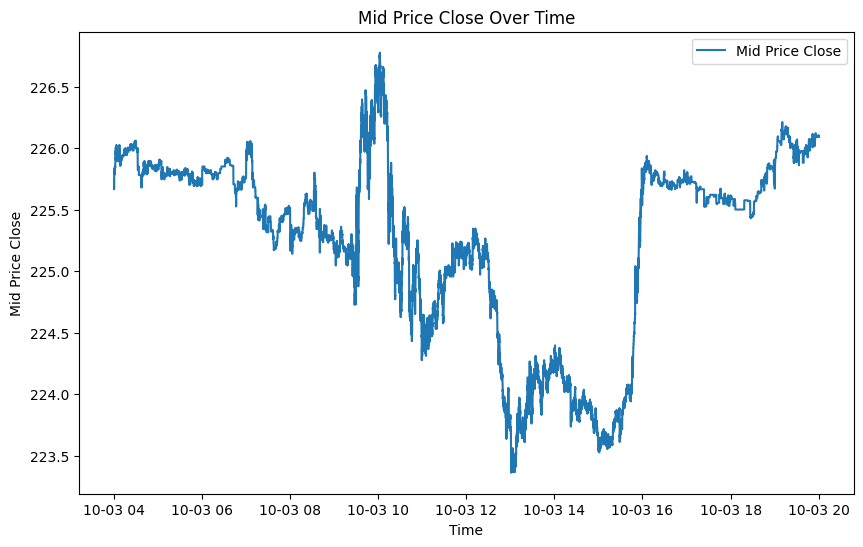

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(mid_prices.index, mid_prices['mid_price_close'], label='Mid Price Close')
plt.title('Mid Price Close Over Time')
plt.xlabel('Time')
plt.ylabel('Mid Price Close')
plt.legend()
plt.show()

In [7]:
# Group by ts_event, action, and side, then sum the sizes
grouped = df.groupby([pd.Grouper(freq='s'), 'action', 'side'])['size'].sum().reset_index()

# Pivot the table to create new columns for each combination of action and side
order_sizes = grouped.pivot_table(index='ts_event', columns=['action', 'side'], values='size', fill_value=0)

order_sizes.drop(columns=[('A', 'N'), ('C', 'N'), ('T', 'N')], inplace=True)

action_mapping = {'A': 'add', 'C': 'cancel', 'T': 'trade'}
side_mapping = {'A': 'ask', 'B': 'bid'}

order_sizes.columns = [f'{action_mapping[action]}_{side_mapping[side]}_size' for action, side in order_sizes.columns]

order_sizes = order_sizes.reindex(mid_prices.index, fill_value=0)

order_sizes.head()


,add_ask_size,add_bid_size,cancel_ask_size,cancel_bid_size,trade_ask_size,trade_bid_size
ts_event,,,,,,
2024-10-03 04:00:02-04:00,638.0,2333.0,440.0,1173.0,0.0,110.0
2024-10-03 04:00:04-04:00,0.0,0.0,0.0,0.0,0.0,0.0
2024-10-03 04:00:06-04:00,1005.0,10.0,0.0,0.0,0.0,0.0
2024-10-03 04:00:08-04:00,37.0,119.0,0.0,0.0,0.0,0.0
2024-10-03 04:00:10-04:00,250.0,237.0,200.0,30.0,0.0,0.0


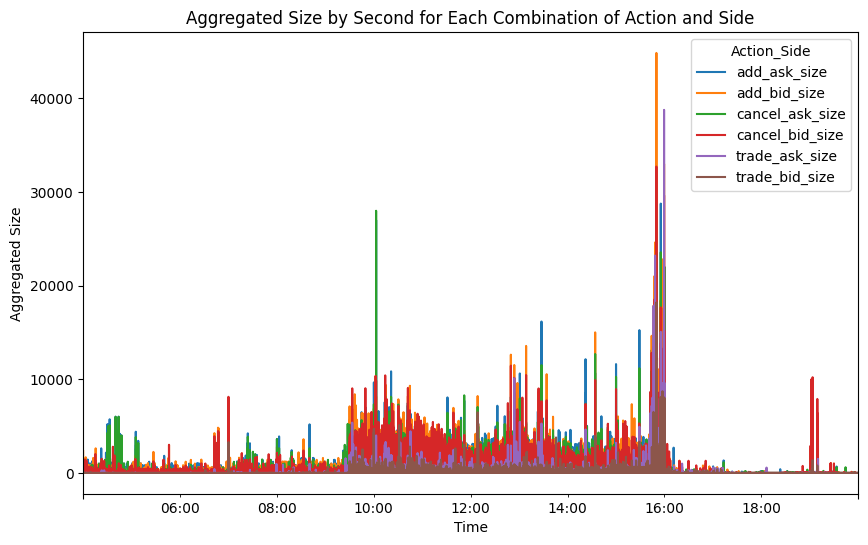

In [8]:
order_sizes.plot(figsize=(10, 6))
plt.title('Aggregated Size by Second for Each Combination of Action and Side')
plt.xlabel('Time')
plt.ylabel('Aggregated Size')
plt.legend(title='Action_Side')
plt.show()

In [9]:
combined_df = pd.concat([mid_prices, order_sizes], axis=1)

combined_df.head()

,mid_price_high,mid_price_low,mid_price_close,mid_price_open,mid_price_mean,Returns,Target,add_ask_size,add_bid_size,cancel_ask_size,cancel_bid_size,trade_ask_size,trade_bid_size
ts_event,,,,,,,,,,,,,
2024-10-03 04:00:02-04:00,226.690,225.555,225.735,225.580,225.794365,0.000687,1.0,638.0,2333.0,440.0,1173.0,0.0,110.0
2024-10-03 04:00:04-04:00,225.745,225.665,225.665,225.735,225.706667,-0.000310,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-10-03 04:00:06-04:00,225.665,225.665,225.665,225.665,225.665000,0.000000,0.0,1005.0,10.0,0.0,0.0,0.0,0.0
2024-10-03 04:00:08-04:00,225.665,225.665,225.665,225.665,225.665000,0.000000,0.0,37.0,119.0,0.0,0.0,0.0,0.0
2024-10-03 04:00:10-04:00,225.680,225.665,225.675,225.665,225.673182,0.000044,1.0,250.0,237.0,200.0,30.0,0.0,0.0


In [11]:
import ta

def compute_hft_indicators(df):
    """
    Compute high-frequency trading (HFT) indicators on second-level price data.
    Returns a new DataFrame with additional features.
    """
    indicators = df.copy()  # Create a copy to avoid modifying the original DataFrame

    # Faster Moving Averages
    indicators['EMA_5'] = ta.trend.ema_indicator(indicators['mid_price_close'], window=5)
    indicators['MA_5'] = indicators['mid_price_close'].rolling(window=5, min_periods=1).mean()

    # Bollinger Bands (adjusted to MA_5)
    indicators['Bollinger_Upper'] = indicators['MA_5'] + (indicators['mid_price_close'].rolling(5).std() * 2)
    indicators['Bollinger_Lower'] = indicators['MA_5'] - (indicators['mid_price_close'].rolling(5).std() * 2)

    # Compute DMP & DMN 
    indicators['High_Shift'] = indicators['mid_price_high'].shift(1)
    indicators['Low_Shift'] = indicators['mid_price_low'].shift(1)

    dmp_raw = np.where(
        (indicators['mid_price_high'] - indicators['High_Shift'] > indicators['Low_Shift'] - indicators['mid_price_low']),
        np.maximum(indicators['mid_price_high'] - indicators['High_Shift'], 0),
        0
    )

    dmn_raw = np.where(
        (indicators['Low_Shift'] - indicators['mid_price_low'] > indicators['mid_price_high'] - indicators['High_Shift']),
        np.maximum(indicators['Low_Shift'] - indicators['mid_price_low'], 0),
        0
    )

    indicators['DMP_3'] = pd.Series(dmp_raw, index=df.index).rolling(3, min_periods=1).sum()
    indicators['DMN_3'] = pd.Series(dmn_raw, index=df.index).rolling(3, min_periods=1).sum()

    indicators['OLL3'] = indicators['mid_price_open'] - indicators['mid_price_low'].rolling(window=3, min_periods=1).min()
    indicators['OLL5'] = indicators['mid_price_open'] - indicators['mid_price_low'].rolling(window=5, min_periods=1).min()

    indicators['STOCHk_7_3_3'] = ta.momentum.stoch(
        indicators['mid_price_high'], indicators['mid_price_low'], indicators['mid_price_close'], window=7, smooth_window=3
    )
    indicators['STOCHd_7_3_3'] = indicators['STOCHk_7_3_3'].rolling(3, min_periods=1).mean()

    # Drop temp columns
    indicators.drop(columns=['High_Shift', 'Low_Shift'], inplace=True)

    return indicators

# Example usage
df_hft = compute_hft_indicators(combined_df)

df_hft = df_hft.ffill()

last_nan_index = df_hft[df_hft.isna().any(axis=1)].index[-1]

df_hft = df_hft.iloc[df_hft.index.get_loc(last_nan_index)+1 :]

df_hft.head()

,mid_price_high,mid_price_low,mid_price_close,mid_price_open,mid_price_mean,Returns,Target,add_ask_size,add_bid_size,cancel_ask_size,...,EMA_5,MA_5,Bollinger_Upper,Bollinger_Lower,DMP_3,DMN_3,OLL3,OLL5,STOCHk_7_3_3,STOCHd_7_3_3
ts_event,,,,,,,,,,,,,,,,,,,,,
2024-10-03 04:00:14-04:00,225.795,225.795,225.795,225.795,225.79500,0.000000,0.0,1000.0,610.0,0.0,...,225.744849,225.719,225.857996,225.580004,0.130,0.0,0.130,0.130,21.145374,21.145374
2024-10-03 04:00:16-04:00,225.795,225.795,225.795,225.795,225.79500,0.000000,0.0,0.0,230.0,0.0,...,225.761566,225.745,225.882113,225.607887,0.115,0.0,0.115,0.130,100.000000,60.572687
2024-10-03 04:00:18-04:00,225.835,225.790,225.800,225.790,225.80625,0.000022,1.0,200.0,0.0,0.0,...,225.774377,225.772,225.880536,225.663464,0.040,0.0,0.000,0.125,79.411765,66.852380
2024-10-03 04:00:20-04:00,225.835,225.835,225.835,225.835,225.83500,0.000155,1.0,0.0,0.0,0.0,...,225.794585,225.804,225.838928,225.769072,0.040,0.0,0.045,0.155,100.000000,93.137255
2024-10-03 04:00:22-04:00,225.835,225.835,225.835,225.835,225.83500,0.000000,0.0,0.0,0.0,0.0,...,225.808057,225.812,225.854190,225.769810,0.040,0.0,0.045,0.045,100.000000,93.137255


In [12]:
df_hft["Target"].value_counts()

Target
 0.0    17419
 1.0     5817
-1.0     5554
Name: count, dtype: int64